We will do some basic analysis on the MovieLens data and see how content-based RS works. 
Few tricks from: https://github.com/khanhnamle1994/movielens/blob/master/Content_Based_and_Collaborative_Filtering_Models.ipynb


In [245]:
# Import packages
import os
import pandas as pd

In [246]:
# Read the Movies File
movies = pd.read_csv('data/movies.dat', sep='::', engine='python', encoding='latin-1',names=['movie_id', 'title', 'genres'])


In [247]:
# Save into movies.csv
movies.to_csv('data/movies.csv', sep='\t', header=True, columns=['movie_id', 'title', 'genres'], index=False)

In [248]:
# Specify User's Age and Occupation Column
AGES = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
OCCUPATIONS = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
                17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }

In [249]:
# Read the Users File
users = pd.read_csv('data/users.dat', sep='::', engine='python', encoding='latin-1',names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
#users['age_desc'] = users['age'].apply(lambda x: AGES[x])
users['occ_desc'] = users['occupation'].apply(lambda x: OCCUPATIONS[x])

In [250]:
users.to_csv('data/users.csv', sep='\t', header=True, encoding='latin-1', columns=['user_id', 'gender', 'age', 'occupation', 'zipcode', 'occ_desc'], index=False)

In [251]:
# Read the Ratings File
ratings = pd.read_csv('data/ratings.dat', sep='::', engine='python', encoding='latin-1',names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Set max_userid to the maximum user_id in the ratings
max_userid = ratings['user_id'].drop_duplicates().max()
# Set max_movieid to the maximum movie_id in the ratings
max_movieid = ratings['movie_id'].drop_duplicates().max()


max_userid, max_movieid
# The dataset contain 1,000,209 anonymous 
# ratings of 3952 movies made by 6040 MovieLens users who 
# joined MovieLens in 2000.

(6040, 3952)

In [252]:
# Save into ratings.csv
ratings.to_csv('data/ratings.csv', sep='\t', header=True, encoding='latin-1', columns=['user_id', 'movie_id', 'rating', 'timestamp'], index=False)

Now, we will have a look at these file and prepare data. 

In [253]:
import numpy as np
import matplotlib.pyplot as plt

# Reading ratings file
# Ignore the timestamp column
ratings = pd.read_csv('data/ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])

# Reading users file
users = pd.read_csv('data/users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('data/movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

In [254]:
ratings.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [255]:
users.head()

,user_id,gender,zipcode,occ_desc
0,1,F,48067,K-12 student
1,2,M,70072,self-employed
2,3,M,55117,scientist
3,4,M,02460,executive/managerial
4,5,M,55455,writer


In [256]:
print(ratings.info(), users.info(), movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   user_id   1000209 non-null  int64
 1   movie_id  1000209 non-null  int64
 2   rating    1000209 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   6040 non-null   int64 
 1   gender    6040 non-null   object
 2   zipcode   6040 non-null   object
 3   occ_desc  6040 non-null   object
dtypes: int64(1), object(3)
memory usage: 188.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genre

In [257]:
ratings['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

<Axes: xlabel='rating', ylabel='Count'>

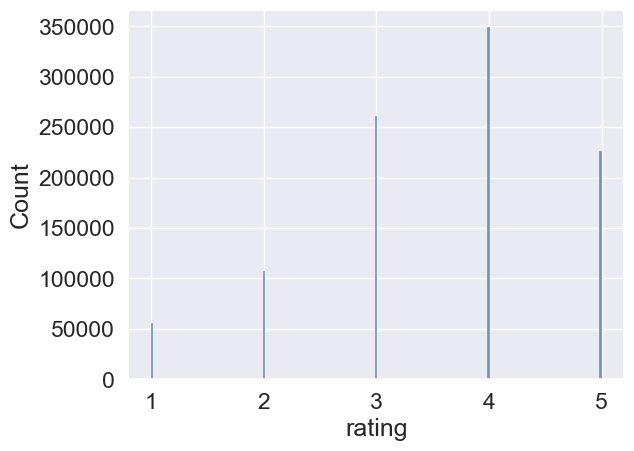

In [258]:
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.histplot(ratings['rating'].fillna(ratings['rating'].median()))

In [259]:
# Join all 3 files into one dataframe
dataset = pd.merge(pd.merge(movies, ratings),users)
# Display 20 movies with highest ratings
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(20)

,title,genres,rating
0,Toy Story (1995),Animation|Children's|Comedy,5
489283,American Beauty (1999),Comedy|Drama,5
489259,Election (1999),Comedy,5
489257,"Matrix, The (1999)",Action|Sci-Fi|Thriller,5
489256,Dead Ringers (1988),Drama|Thriller,5
489237,Rushmore (1998),Comedy,5
489236,"Simple Plan, A (1998)",Crime|Thriller,5
489226,Hands on a Hard Body (1996),Documentary,5
489224,Pleasantville (1998),Comedy,5
489212,Say Anything... (1989),Comedy|Drama|Romance,5


In [260]:
# Look at genres

import plotly.express as px
genres_value_counts = movies['genres'].str.split('|', expand=True).stack().value_counts()
fig = px.bar(genres_value_counts, x=genres_value_counts.index, y=genres_value_counts, text=genres_value_counts,
             labels={
                 "index": "Genres",
                 'y': 'Frequency'},
             color=genres_value_counts**0.50
             )
fig.update_traces(textposition='outside')
fig.update_layout(title_text='Top Frequent the Movie Genres',
                  title_x=0.5, title_font=dict(size=24))
fig.update_traces(marker=dict(line=dict(color='#032323', width=2)))
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 1, 0)'})
fig.show()

In [261]:
# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),"['Animation', ""Children's"", 'Comedy']"
1,2,Jumanji (1995),"['Adventure', ""Children's"", 'Fantasy']"
2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']"
3,4,Waiting to Exhale (1995),"['Comedy', 'Drama']"
4,5,Father of the Bride Part II (1995),['Comedy']


In [262]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape
# https://masongallo.github.io/machine/learning,/python/2016/07/29/cosine-similarity.html



(3883, 127)

In [263]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(3883, 3883)

In [264]:
cosine_sim[:5, :5] # Diagonal must be 1 

array([[1.        , 0.14193614, 0.09010857, 0.1056164 , 0.23523322],
       [0.14193614, 1.        , 0.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 , 0.38306058],
       [0.1056164 , 0.        , 0.1719888 , 1.        , 0.4489859 ],
       [0.23523322, 0.        , 0.38306058, 0.4489859 , 1.        ]])

In [265]:
# Build a 1-dimensional array with movie titles

how_many_to_recommend = 10
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title] # id of title  
    sim_scores = list(enumerate(cosine_sim[idx])) # sim_scores of "title" with all movies 
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) # Sort descending 
    sim_scores = sim_scores[1:how_many_to_recommend+1]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [266]:
genre_recommendations('Good Will Hunting (1997)').head(10)

25                                       Othello (1995)
26                                  Now and Then (1995)
29    Shanghai Triad (Yao a yao yao dao waipo qiao) ...
30                               Dangerous Minds (1995)
35                              Dead Man Walking (1995)
39                      Cry, the Beloved Country (1995)
42                                   Restoration (1995)
52                                      Lamerica (1994)
54                                       Georgia (1995)
56                         Home for the Holidays (1995)
Name: title, dtype: object

Overall, here are the pros of using content-based recommendation:

- No need for data on other users
- Can recommend to users with unique tastes.
- Can recommend new & unpopular items.

However, there are some cons of using this approach:

- Finding the appropriate features is hard.
- Does not recommend items outside a user's content profile.
- Unable to exploit quality judgments of other users.